# **PRACTICA 3**  

## PARTE 1

# Instalación de Librerias

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import kagglehub  # Asegúrate de tener kagglehub instalado pip install kagglehub

# Descargar dataset desde Kaggle

In [189]:
path = kagglehub.dataset_download("teamincribo/cyber-security-attacks")

# Cargar archivo CSV (puedes ajustar el nombre si es diferente)

In [190]:
df = pd.read_csv(f"{path}/cybersecurity_attacks.csv")
#df = pd.read_csv(f"/workspaces/practica_tres_gr_3/cybersecurity_attacks.csv")

#################################################################################

# Paso 1: Limpiar columnas necesarias

In [191]:
df2 = df[['Timestamp', 'Source IP Address', 'Attack Type', 'Attack Signature']].copy()

# Paso 2: Eliminar registros con campos nulos

In [192]:
df2.dropna(inplace=True)

# Paso 3: Validar IPs válidas (IPv4)

In [193]:
df2 = df2[df2['Source IP Address'].str.match(r"^\d{1,3}(\.\d{1,3}){3}$", na=False)]

# Paso 4: Eliminar registros con campos vacíos después de limpiar espacios

In [194]:
df2 = df2[(df2['Attack Type'].str.strip() != "") & (df2['Attack Signature'].str.strip() != "")]

# Paso 5: Seleccionar los primeros 10 registros válidos

In [195]:
subset = df2.head(10)
print(f"✅ Se encontraron {len(subset)} registros válidos para insertar en la base de datos.")

✅ Se encontraron 10 registros válidos para insertar en la base de datos.


#################################################################################

# Seleccionar solo algunas columnas y los primeros 10 registros

In [196]:
subset = df[['Timestamp', 'Source IP Address', 'Attack Type', 'Attack Signature']].head(10)

In [197]:
# Paso 2: Conectarse a PostgreSQL

In [198]:
# Paso 2: Conectarse a PostgreSQL
conn = psycopg2.connect(
    database="cybersecurity",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)
cursor = conn.cursor()

# Paso 3: Crear la tabla si no existe

In [199]:
cursor.execute("""
    CREATE TABLE IF NOT EXISTS registros (
        id SERIAL PRIMARY KEY,
        timestamp TIMESTAMP NOT NULL,
        ip_address VARCHAR(50),
        tipo_evento VARCHAR(50),
        descripcion TEXT
    );
""")
conn.commit()

# Paso 4: Recorrer e insertar los registros uno por uno

In [200]:
for index, row in subset.iterrows():
    cursor.execute("""
        INSERT INTO registros (timestamp, ip_address, tipo_evento, descripcion)
        VALUES (%s, %s, %s, %s);
    """, (row['Timestamp'], row['Source IP Address'], row['Attack Type'], row['Attack Signature']))

conn.commit()
cursor.close()
conn.close()

print("✅ Tabla verificada/creada e inserción de los 10 registros completada.")

✅ Tabla verificada/creada e inserción de los 10 registros completada.


#################################################################################

# Normalizar columnas

In [201]:
df.columns = df.columns.str.strip()

# Convertir 'Timestamp' a datetime

In [202]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Crear columna de hora para análisis por hora

In [203]:
df['Hour'] = df['Timestamp'].dt.hour

# Crear las gráficas

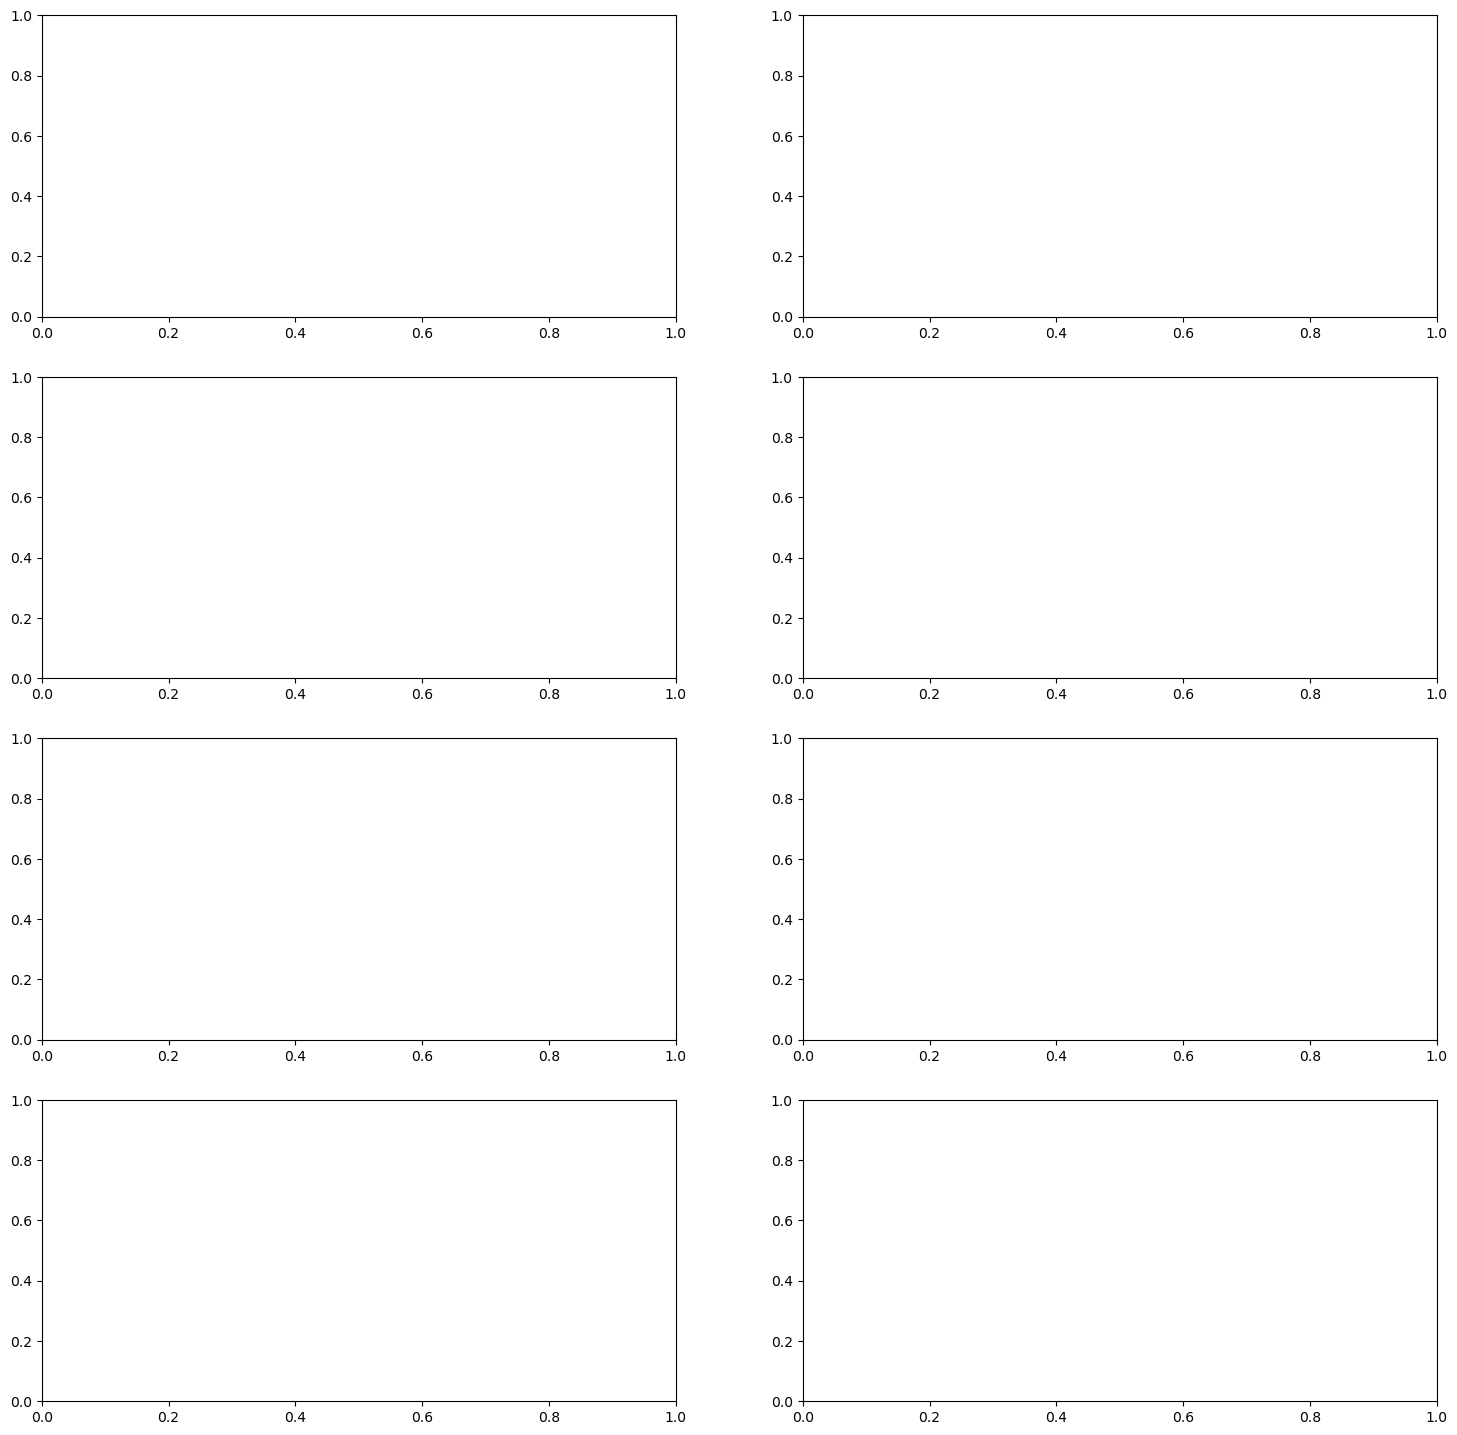

In [204]:
fig, axes = plt.subplots(4, 2, figsize=(18, 18))

In [205]:
# 1. Número de ataques por día

In [206]:
eventos_diarios = df.resample('D', on='Timestamp').size()
axes[0, 0].plot(eventos_diarios.index, eventos_diarios.values, marker='o', linestyle='-', color='b')
axes[0, 0].set_title("Número de ataques por día")
axes[0, 0].set_xlabel("Fecha")
axes[0, 0].set_ylabel("Cantidad de ataques")
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Distribución de niveles de severidad

In [207]:
ax2 = sns.countplot(x="Severity Level", data=df, order=df["Severity Level"].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_title("Distribución por nivel de severidad")
axes[0, 1].set_xlabel("Severidad")
axes[0, 1].set_ylabel("Cantidad")
for container in ax2.containers:
    ax2.bar_label(container, fmt="%d")

# 3. Protocolos más utilizados

In [208]:
ax3 = sns.countplot(y="Protocol", data=df, order=df["Protocol"].value_counts().index, ax=axes[1, 0])
axes[1, 0].set_title("Protocolos más utilizados")
axes[1, 0].set_xlabel("Cantidad")
axes[1, 0].set_ylabel("Protocolo")
for container in ax3.containers:
    ax3.bar_label(container, fmt="%d")

# 4. Tipos de tráfico más comunes

In [209]:
ax4 = sns.countplot(y="Traffic Type", data=df, order=df["Traffic Type"].value_counts().index, ax=axes[1, 1])
axes[1, 1].set_title("Tipos de tráfico más comunes")
axes[1, 1].set_xlabel("Cantidad")
axes[1, 1].set_ylabel("Tipo de tráfico")
for container in ax4.containers:
    ax4.bar_label(container, fmt="%d")

# 5. Frecuencia por hora

In [210]:
ax5 = sns.countplot(x="Hour", data=df, ax=axes[2, 0])
axes[2, 0].set_title("Frecuencia de ataques por hora")
axes[2, 0].set_xlabel("Hora del día")
axes[2, 0].set_ylabel("Cantidad")
for container in ax5.containers:
    ax5.bar_label(container, fmt="%d")

# 6. IPs de origen con más ataques

In [211]:
top_sources = df["Source IP Address"].value_counts().nlargest(10)
ax6 = sns.barplot(x=top_sources.values, y=top_sources.index, ax=axes[2, 1], palette="Reds_r")
axes[2, 1].set_title("Top 10 IPs de origen")
axes[2, 1].set_xlabel("Cantidad de ataques")
axes[2, 1].set_ylabel("IP origen")
ax6.bar_label(ax6.containers[0], fmt="%d")

/tmp/ipykernel_1574/169800708.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax6 = sns.barplot(x=top_sources.values, y=top_sources.index, ax=axes[2, 1], palette="Reds_r")


[Text(0, 0, '1')]

# 7. IPs de destino con más ataques

In [212]:
top_dest = df["Destination IP Address"].value_counts().nlargest(10)
ax7 = sns.barplot(x=top_dest.values, y=top_dest.index, ax=axes[3, 0], palette="Blues_r")
axes[3, 0].set_title("Top 10 IPs de destino")
axes[3, 0].set_xlabel("Cantidad de ataques")
axes[3, 0].set_ylabel("IP destino")
ax7.bar_label(ax7.containers[0], fmt="%d")

/tmp/ipykernel_1574/1633521977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax7 = sns.barplot(x=top_dest.values, y=top_dest.index, ax=axes[3, 0], palette="Blues_r")


[Text(0, 0, '1')]

# 8. Acciones tomadas

In [213]:
ax8 = sns.countplot(x="Action Taken", data=df, order=df["Action Taken"].value_counts().index, ax=axes[3, 1])
axes[3, 1].set_title("Acciones tomadas ante ataques")
axes[3, 1].set_xlabel("Acción")
axes[3, 1].set_ylabel("Cantidad")
for container in ax8.containers:
    ax8.bar_label(container, fmt="%d")



In [214]:
plt.tight_layout()
plt.savefig('dashboard_cyberseguridad_kaggle.png')
plt.show()

<Figure size 640x480 with 0 Axes>